# Complex Networks Project - ENS Lyon - 2019

# Introduction

In this project, the **gene regulatory network** of *Saccharomyces cerevisiae*, a yeast (which is a single-cell organism), is studied. It was used as a gold-standard to assess gene regulatory network inference methods in [1]. It was based on the results of biological experiments [2], [3].

A gene is considered here to be a sequence of DNA that codes instructions for the synthesis of RNA, which itself codes instructions for the synthesis of a protein. The synthesis of RNA from a gene is called transcription and the synthesis of a protein from an RNA is called translation (cf. figure below). When a gene is transcribed into an RNA that is then translated into a protein, it is said that the gene is expressed. Some proteins, called transcription factors (TF), can regulate whether a gene is, or is not, transcribed. TFs can also regulate genes that code for other transcription factors. Here, as an approximation, genes coding for TFs will be called TFs. To describe these regulations, gene regulatory networks can be inferred where **nodes** are genes or TFs and **directed edges** embody the following relationships: TFs (source nodes) regulate genes or other TFs (target nodes).

It is widely believed that gene regulatory networks are scale-free [5]. First, whether the scale-free model could be appropriate in this case will be verified. Then different properties of the graph will be explored, such as its assortativity. In addition, in [1], using Newman's spectral method [4], it is shown that the network we are studying contains several communities corresponding to different biological functions. In this project, Louvain's method will be used to try to find communities in this network.

<img src="0328_Transcription-translation_Summary.jpg" width=350 height=50/ title="Gene Expression schema. (source=https://cnx.org/contents/FPtK1zmh@8.25:fEI3C8Ot@10/Preface)">

### Libraries

In [560]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [618]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
import networkx as nx
import itertools
from networkx.drawing.nx_agraph import graphviz_layout
import collections
from networkx.algorithms.richclub import rich_club_coefficient 
import seaborn as sns 
import random 
import math
import statistics as stat
from operator import itemgetter
#from community import community_louvain
from networkx.algorithms import community as c
from itertools import count
from sklearn.linear_model import LinearRegression
from scipy.stats import powerlaw
import community

## import functions written for this project
import functions as f

# Data

## Description of the Data

The data used in this project consists of the following files [1]:
- The file **GRN_edges_S_cerevisia.txt** is the edge list of the *Saccharomyces cerevisiae* gene regulatory network. It contains two columns: the first one refers to the transcription factors and the second one to their target genes. 
- The file **net4_transcription_factors.tsv** contains the transcription factors ids.
- The file **net4_gene_ids.tsv** contains all gene ids and their corresponding common name. In essence, this file lists all the nodes of the network. This supplementary information allows to find genes of interest in databases and to cross-reference them with the last file. 
- The file **go_slim_mapping.tab.txt** contains, for each gene, :
    - the common gene name,
    - its  SGD id ( Saccharomyces Genome Database)
    - its Aspect, this field contained a single letter which could be : P (= biological Process), F  (= Functional process) or C (cellular Component),
    - its GO id,
    - its object type, that is to say the type of the gene product, (e.g., protein).

Only the "common gene name" and "GO id" columns will be used in this project. With the increasing amount of biological data, the Gene Ontology (GO) was created to store gene informations in a computable form. In this format, each gene is described according to the molecular function of the gene product, the biological component where the gene product performs a function on and the main biological process accomplished by the molecular activity. 

## Loading the Data

### Data of the transcription factors ids and target gene ids

In [562]:
edges = pd.read_csv('GRN_edges_S_cerevisiae.txt')# load the nodes labels from GRN_edges_S_cerevisiae.txt
edges = edges.set_index('Unnamed: 0') # set index with first column
edges.index.names = ['id'] # rename index column header to 'id'

In [563]:
edges.head()

,transcription_factor,target_gene
id,,
0,G15,G1
1,G98,G1
2,G109,G1
3,G22,G9
4,G211,G11


### Data of the transcription factors ids

In [564]:
transcription_factors_id = pd.read_csv('net4_transcription_factors.tsv')

### Data of the genes ids and their name (Nodes Dataframe)

In [565]:
genes_id = pd.read_csv('net4_gene_ids.tsv', sep ='\t')

### Data set describing genes function

In [636]:
gene_go_mapping = pd.read_csv('go_slim_mapping.tab.txt', sep='\t', header=None)
gene_go_mapping = gene_go_mapping.drop(gene_go_mapping.columns[[1, 2, 3, 4,6]], axis=1) # keeping columns 0 and 5 only

### Renaming the genes ids by their name in the graph

In [574]:
genes_name_edges = [] # list of target gene names in the network
y = genes_id['ID'] # list of genes ID
for x in edges['target_gene'] :
    i = list(y[y==x].index)[0] # index of the gene 'x' in the list of gene IDs
    genes_name_edges.append(genes_id['Name'][i])

    
# replacing the genes ids in the graph by their corresponding name
named_edges = edges.copy()
named_edges['target_gene_name']=genes_name_edges

In [573]:
# first edges in the graph (where gene ids were replaced by gene names)
named_edges.head()

,transcription_factor,target_gene,target_gene_name
id,,,
0,G15,G1,YHR084W
1,G98,G1,YHR084W
2,G109,G1,YHR084W
3,G22,G9,YBR150C
4,G211,G11,YGL071W


## Exporting the Nodes and Edges Dataframes to csv

<div style="text-align: justify">
In the this project, we will use Gephi to visualize the network. Thus, we need to export the dataframe containing the renamed edges to a csv file, which is a format supported by Gephi:

In [352]:
# first rename the headers to match Gephi requirements
genes_id = genes_id.rename(columns={"ID": "Id", "Name": "Label"}) # nodes dataframe
named_edges = named_edges.rename(columns={"transcription_factor": "Source", "target_gene":"Target"}) # edge dataframe
# then export to csv
genes_id.to_csv(r'GRN_renamed_nodes.csv', index=False)
named_edges.to_csv(r'GRN_renamed_edges.csv', index=False)

## NetworkX graph instance

In [353]:
DG=nx.from_pandas_edgelist(edges, 'transcription_factor', 'target_gene', create_using= nx.DiGraph())

# General Information

In [544]:
# number of nodes and edges
print('# nodes: ', len(DG.nodes()), ', # edges:', len(DG.edges()))

# degree disrtribution
deg=[d for n, d in DG.degree()]
# in-degree distribution
in_deg=[d for n, d in DG.in_degree()]
# out-degree distribution
out_deg=[d for n, d in DG.out_degree()]
# averages
print( "average degree: ", stat.mean(deg), ", average in-degree: ", stat.mean(in_deg), ", average out-degree: ", stat.mean(out_deg))

# number of connected components
print("number of connected components: ", nx.number_connected_components(nx.DiGraph.to_undirected(DG)))
# average shortest path length
#print('average path length: ', nx.average_shortest_path_length(DG))
i=0
for g in nx.connected_component_subgraphs(nx.DiGraph.to_undirected(DG)):
    i+=1
    print("Component #", i, " size: ", len(g.nodes()), ", average path legth: ",  nx.average_shortest_path_length(g))

# nodes:  1994 , # edges: 3940
average degree:  3.9518555667001003 , average in-degree:  1.9759277833500501 , average out-degree:  1.9759277833500501
number of connected components:  4
Component # 1  size:  1984 , average path legth:  3.9478734566395004
Component # 2  size:  3 , average path legth:  1.3333333333333333
Component # 3  size:  2 , average path legth:  1.0
Component # 4  size:  5 , average path legth:  1.6


In [355]:
math.log(1984)/math.log(math.log(1984))

3.7454784952335247

This graph consists of 1994 nodes and 3940 edges. It has four connected components. This could be interpreted as the fact that there could be four independent sub-regulatory networks. The largest one contains 1984 nodes and its average shortest path length is 3.94, which is approximately equal to $\frac{ln(N)}{ln(ln(N))}$ (with N the number of nodes). Thus it is an **ultra-small world** network.The other three components contain five or less nodes.

# Degree 

## First Visualization

<div style="text-align: justify">
The entire network can be visualized using Gephi. In this first visualization, the darker and bigger the node, the higher its degree. The Force Atlas layout algorithm was used with a repulsion strength of 10,000.

<img src="screenshot_color_size_degree_idsANDlabels.png" width=500 height=100/ title="Visualization of the network using Gephi.">

The biggest nodes (i.e., the ones with the highest degree), such as **G41** and **G138**, are all TFs. Indeed, their degree is, respectively, 219&mdash;which is the maximum degree&mdash;and 199. 

In [356]:
print( "max:", max([d for n, d in DG.degree()]), ", G41:", DG.degree['G41'], ", G138:", DG.degree['G138'])

max: 219 , G41: 219 , G138: 199


In [357]:
print("The gene is a TF: G41:", "G41" in set(transcription_factors_id.iloc[:,0]), "G138:", "G138" in set(transcription_factors_id.iloc[:,0]))

The gene is a TF: G41: True G138: True


This graph is directed, so it would be interesting to rank nodes by their in- and out-degree.

<img src="screenshot_color_size_OUTdegree_idsANDlabels.png" width=45% style="display:inline"/> <img src="screenshot_color_size_INdegree_idsANDlabels.png" width=45% style="display:inline">

Without changing the layout, the above visualizations were obtained: on the left-hand side (in __green__), nodes were ranked by their __out-degree__ and on the right-hand side (in __blue__), nodes were ranked by their __in-degree__. We can notice that the nodes with the highest degrees (i.e., the TFs) seem to be the same as the ones with the highest out-degrees. However, it seems that the nodes with the highest degrees (and out-degrees) have very low in-degrees. For instance,  the in-degree of __G41__ and __G138__ is 0. Moreover, the nodes with the highest in-degrees are target genes, like __G4176__ and __G1773__. Indeed, both of their in-degree is 14 &mdash;which is the maximum in-degree. This is coherent with the way the graph was defined. Indeed, source nodes are TFs and target nodes are target genes.

In [358]:
print("The gene is a TF: G417:", "G417" in set(transcription_factors_id.iloc[:,0]), "G1773:", "G1773" in set(transcription_factors_id.iloc[:,0]))

The gene is a TF: G417: False G1773: False


In [359]:
print( "max in-degree:", max([d for n, d in DG.in_degree()]), ", G41:", DG.in_degree['G41'], ", G138:", DG.in_degree['G138'], ", G4176:", DG.in_degree['G4176'], ", G1773:", DG.in_degree['G1773'])

max in-degree: 14 , G41: 2 , G138: 0 , G4176: 14 , G1773: 14


In [360]:
print( "max out-degree:", max([d for n, d in DG.out_degree()]), ", G41:", DG.out_degree['G41'], ", G138:", DG.out_degree['G138'], ", G4176:", DG.out_degree['G4176'], ", G1773:", DG.out_degree['G1773'])

max out-degree: 217 , G41: 217 , G138: 199 , G4176: 0 , G1773: 0


## Plotting the Degree Distribution &ndash; Scale-free network?

The next step is to try to ascertain whether the network is scale-free. To begin with, the different types of degree distributions were plotted and compared with those of different random graphs. Then, the degree distribution was fitted to a power-law.

### Degree Distribution

The degree distribution is plotted below. The degree was cut off at 20 in order to be able to visualize the distribution form. Indeed, the maximum degree is 219 and there is only one node with such a degree. In addition, there are 1046 nodes of degree 1 and there are few nodes of high degree. Hence, it seems plausible that the network could be scale-free.

In [361]:
from collections import Counter
# count the number of nodes per degree category
c=Counter(degree_sequence)

Text(0, 0.5, 'density')

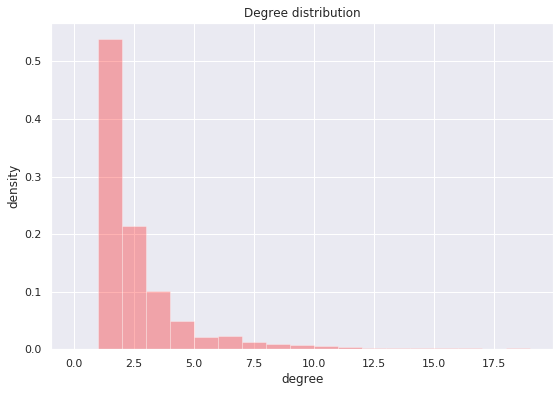

In [554]:
## degrees
degree_sequence = sorted([d for n, d in DG.degree()], reverse=True)
## plot
sns.set(rc={'figure.figsize':(9,6)})
plt.hist(degree_sequence, density=True, bins = np.arange(0,20,1), alpha=0.3, color='red')

plt.title('Degree distribution')
plt.xlabel('degree')
plt.ylabel('density')

Then, the degree distribution is qualitatively compared to that of different types of random models. Only one set of parameter per random graph is tested.

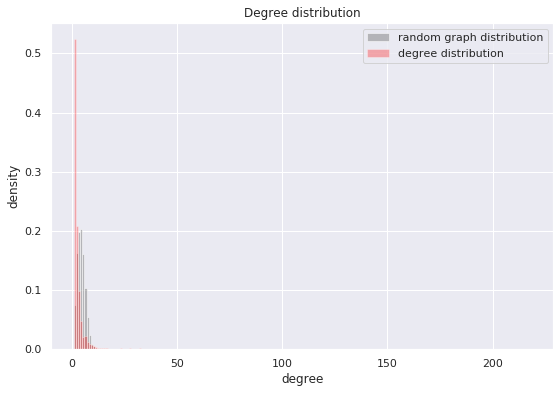

In [428]:
sns.set(rc={'figure.figsize':(9,6)})
# Erdos-Renyi random graph
H=f.Hist_degree(DG,9.9*10**(-4), 'ER', "both")

In [429]:
max([H[2].degree()[i] for i in range(len(H[2].degree()))])

12

A high number of genes with a low degree of interaction can be observed. This proportion is highly greater than the one expected in the Erdös-Rényi random graph. Moreover, few genes have a very high degree of interaction. This proportion is  over the one expected in random case. Additionally, the maximum degree of the random network is 12, which is a lot smaller than the one from the real network.

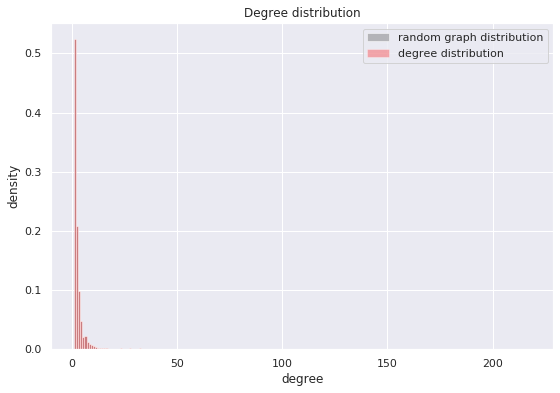

In [431]:
sns.set(rc={'figure.figsize':(9,6)})
# Configuration Model random graph
H=f.Hist_degree(DG,9.9*10**(-4), 'CM', "both")

As expected, the degree distribution of the configuration model is the same as the one from the network studied. Indeed, configuration models, by definition, preserve degree distributions.

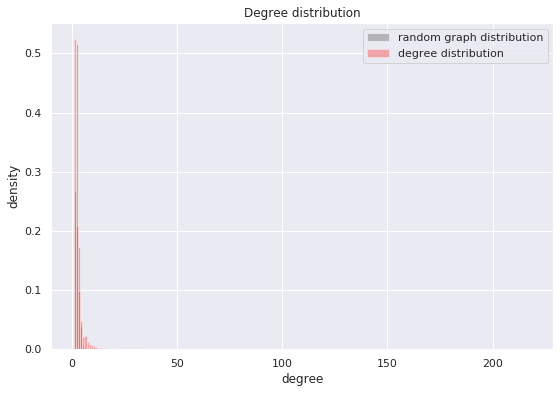

In [435]:
sns.set(rc={'figure.figsize':(9,6)})
# Watts Strogatz random graph
H=f.Hist_degree(DG,.4, 'WS', "both")

In [436]:
max([H[2].degree()[i] for i in range(len(H[2].degree()))])

6

The degree distribution is closer to the real distribution than the one obtained with an Erdös-Rényi random graph. However, this network does not have nodes with degree greater than 6, unlike the real network.

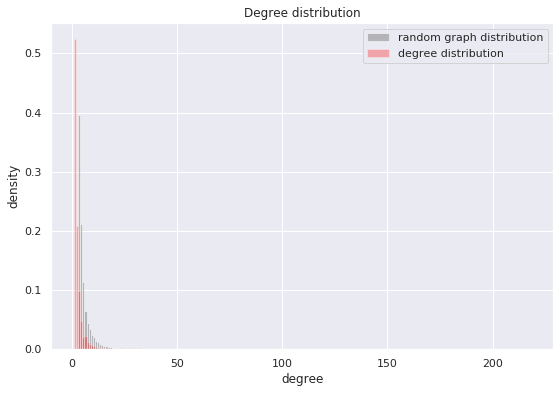

In [445]:
sns.set(rc={'figure.figsize':(9,6)})
# Watts Strogatz random graph
H=f.Hist_degree(DG,9.9*10**(-4), 'BA', "both")

In [444]:
max([H[2].degree()[i] for i in range(len(H[2].degree()))])

183

Finally, the real degree distribution is compared with one from a Barabasi-Albert random graph. The form of the distribution is similar to the real one. In addition, the maximum degree is 184, which is closer to the real one (219). The Barabasi-Albert model generates scale-free graphs. Thus, it provides more assurance towards the hypothesis of a scale-free gene regulatory network.

### Linear Regression to fit a power-law

The next step is thus to try to fit the real network degree distribution to a power-law.

In [96]:
# export the degree distribution to fit it in R
degree_sequence=pd.DataFrame(degree_sequence)
degree_sequence.to_csv("degree_distrib.txt", sep=' ', index=False, header=False)

In [ ]:
import powerlaw

# powerlaw fit
fit=powerlaw.Fit(degree_sequence)
fit.power_law.alpha

# Kolmogorov-Smirnov
fit.power_law.KS()

In order to fit the degree distribution, the 'fit_power_law' method from the R package igraph was used. The fitted exponent was: $\alpha=2.196127$. Additionally, this method carried out a Kolmogorov-Smirnov test that compared the fitted distribution with the input distribution. The corresponding score was $0.0248637$. The p-value associated with this test was about $0.6$, which indicates that the hypothesis that the degree distribution follows indeed a power-law cannot be rejected. Furthermore, $2<\alpha<3$. Therefore, the degree distribution can be considered **scale-free**. 

The 'powerlaw.Fit' method from the powerlaw python library was also used. The fitted exponent was $0.66$ and the Kolmogorov-Smirnov score was about $0.0534$, which is greater than the one obtained via thr R method. However, the smaller this score, the better. Thus, it can be considered that the R method provided a better fit than the Python method.

Below, the log-log plot of the degree distribution and its fitted distribution were plotted.

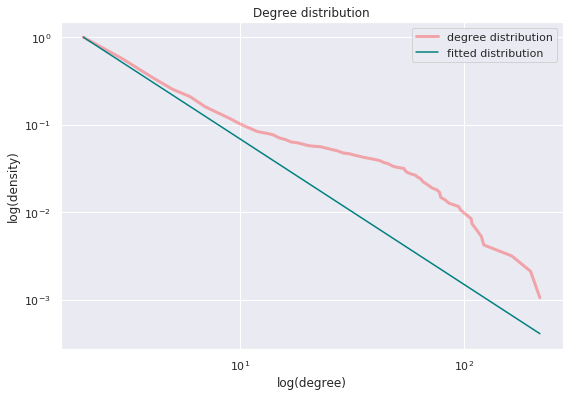

In [314]:
fig4=fit.plot_ccdf(linewidth=3, color='red', alpha=0.3)
#plt.loglog(degree_sequence, alpha=0.3, color='red', marker='o')
fit.power_law.plot_ccdf( color='teal', ax=fig4)

plt.title('Degree distribution')
plt.xlabel('log(degree)')
plt.ylabel('log(density)')
plt.legend(['degree distribution','fitted distribution'])

Below is another type of plot: the histogram of the density and the fitted distribution in a log-log scale.

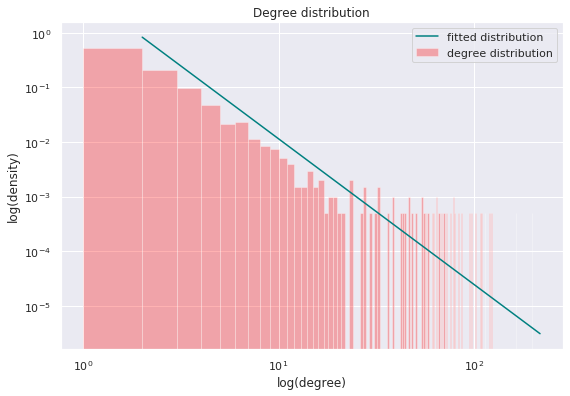

In [474]:
## degrees
degree_sequence = sorted([d for n, d in DG.degree()], reverse=True)
## plot
sns.set(rc={'figure.figsize':(9,6)})
plt.hist(degree_sequence, alpha=0.3, color='red',density=True,log=True,bins = np.arange(0,max(degree_sequence),1))

## power-law
fit.power_law.plot_pdf( color='teal')

plt.title('Degree distribution')
plt.xlabel('log(degree)')
plt.ylabel('log(density)')
plt.legend(['fitted distribution', 'degree distribution'])

### Out-degree Distribution

It would now be interesting to look at the out-degree distribution in order to understand better the interactions in the network. Indeed, nodes with a high out-degree correspond to nodes that regulate a lot of genes. The real distribution was also compared to an Erdös-Rényi random graph out-degree distribution.

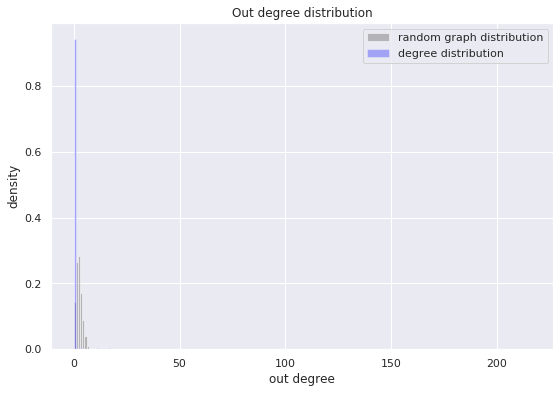

In [517]:
sns.set(rc={'figure.figsize':(9,6)})
# Erdos-Renyi random graph
Hout=f.Hist_degree(DG,9.9*10**(-4), 'ER', "out")

Most of the nodes (94%) in this network have an out-degree that equals 0. These are nodes that do not regulate the expression of other genes. We thus removed the nodes with out-degree 0 from the network in order to obtain a better visualization the out-degree distribution.

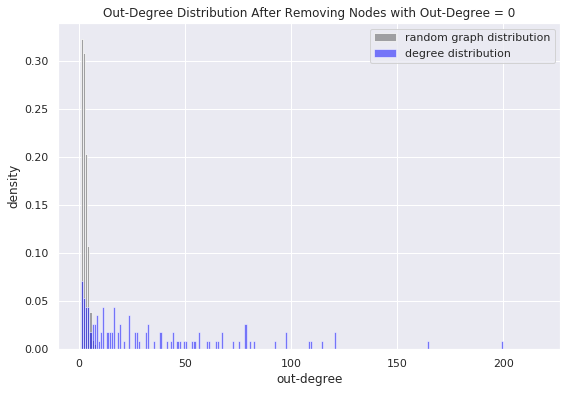

In [519]:
sns.set(rc={'figure.figsize':(9,6)})
# removing nodes of out-degree 0
new_out_degree_sequence=[x for x in H[0] if x!=0] # real distribution
new_out_degree_sequence_random=[x for x in H[1] if x!=0] # random distribution

newbins = np.arange(min(new_out_degree_sequence),max(new_out_degree_sequence),1)

# remove the zeroes

#plot the new distribution
sns.set(rc={'figure.figsize':(9,6)})

plt.hist(new_out_degree_sequence_random, density=True, bins = newbins, alpha=0.7, color='grey')
plt.hist(new_out_degree_sequence, density=True, bins = newbins, alpha=0.5, color='blue')


plt.title('Out-Degree Distribution After Removing Nodes with Out-Degree = 0')
plt.xlabel('out-degree')
plt.ylabel('density')

plt.legend(['random graph distribution', 'degree distribution'])

It can be noted in the distribution induced by the remaining nodes that transcription factors can regulate a highly variable number of genes. Most of these transcription factors control the transcription of a single node, like in the random network. However it can also be remarked that few transcription factors regulates a very high number of genes. The transcription factor with the highest degree regulates 217 genes. This behavior is not showcased in the random network. It seems that the out-degree distribution displays a scale-free-like behavior.

### In-degree Distribution

It would be then interesting to look at the in-degree distribution. It allows one to highlight genes that are finely regulated (i.e., nodes with a high in-degree). A comparison was also carried out with an Erdös-Rényi random graph.

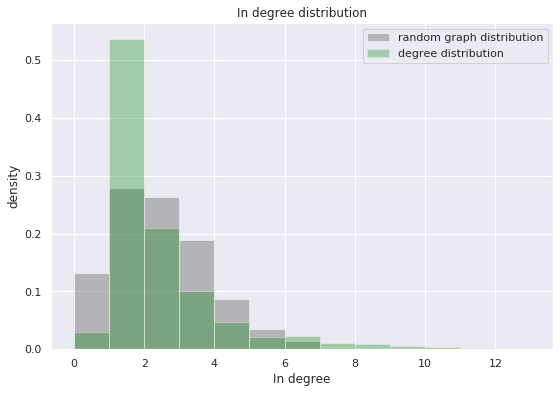

In [547]:
sns.set(rc={'figure.figsize':(9,6)})
# Erdos-Renyi random graph
Hin=f.Hist_degree(DG,9.9*10**(-4), 'ER', "in")

The in-degree distribution shows that most of the genes are regulated by 1 to 4 transcriptions regulators. This is expected given the  average in-degree, which is about 2. Nevertheless, the proportion of nodes with an in-degree equal to 1 is higher than the one expected in a random network. We notice that a non-negligible number of gene are not regulated (i.e., in-degree=0). This is biologically interesting because either these genes have a constitutive expression (i.e., do not need any transcription factor to be expressed), or we could postulate that the transcription factor of these gene have not been discovered yet. A few number of genes have a high in-degree. The gene with the highest in-degree (14) is 'YDR527W', this gene interacts with RNA pol II and is involved in transcription regulation.

# Assortativity: Person coefficient

Another property of the graph is then explored: its assortativity, through the Pearson degree-degree correlation whose formula is:
$$r = \frac{1}{\sigma^2_q}\sum_{k,l} k * l * (e_{kl}- q_k  * q_l)$$

Given a edge $<v_i, v_j>$, $e_{kl}$ represents the probability that the ends of $<v_i, v_j>$ have a degree k and l, $q_k$ is the probability that one end of $<v_i, v_j>$ has a degree k, and reciprocally for $q_l$, $\sigma^2$ is the variance of the distribution $q_k$.
The Pearson degree-degree correlation allows to characterize a graph according to three categories:

- if $r = 0$, the graph is **neutral**. The  nodes with a low dregree could be connected indifferently to high degree nodes or low degree nodes. In the regulatory network studied here, this would mean that transcription factor would be linked with both other transcription factors and others genes.
- $ r<0 $, the graph is **disassortative**. The nodes with a low degree are more likely to be connected with nodes with a high degree. In our network, this would mean that the transcription factors tend to have more links with their targets than links between themselves.
- $r>0$, the graph is **assortative**. The graph edges tend to connect nodes with a similar degree. In our network, this would mean that the transcription factors tend to have more links between themselves than with other genes. 

In [557]:
nx.degree_pearson_correlation_coefficient(DG, x='out', y='in', weight=None, nodes=None)

-0.188799288753497

The assortativity in the gene regulation network studied here is : $ r = -0.189$.
The assortativity calculated is negative, so the network is **disassortative**. A possible interpretation would be that transcription factors are more likely to link with genes that are not transcription factors than with transcription factors. However, the assortativity is quite close to 0 so one needs to remain cautious concerning this conclusion.

# Betweenness Centrality

The betweenness centrality can then be calculated. It is defined by:
$$b_v = \sum_{V_s \neq v \neq V_t} = \frac{\sigma_{V_s, V_t(V)}}{\sigma_{V_s, V_t}}$$
Where $\sigma_{V_s, V_t(V)}$ is the number of shortest path between $s$ and $t$ passing through v, and $ \sigma_{V_s, V_t}$ is the number of shortest path between $s$ and $t$. 

This metric could be useful to identify the most central genes in a network. These genes are probably important transcription factors but they could also be transcription factors that are highly regulated.

In [960]:
bc = nx.betweenness_centrality(DG)

In [968]:
bc_values_no0=[] # betweenness centralities different than 0
k=0 # number of nodes with betweenness centrality equal to 0
for i in bc:
    if bc[i]!=0:
        bc_values_no0.append(bc[i])
    else:
        k+=1
k

1941

In [962]:
max(bc_values_no0)

0.002054588986486169

(array([3306.39641727,  642.91041447,  367.3773797 ,  275.53303477,
           0.        ,    0.        ,    0.        ,  183.68868985,
           0.        ,   91.84434492]),
 array([2.51885616e-07, 2.05685596e-04, 4.11119306e-04, 6.16553016e-04,
        8.21986726e-04, 1.02742044e-03, 1.23285415e-03, 1.43828786e-03,
        1.64372157e-03, 1.84915528e-03, 2.05458899e-03]),
 <a list of 10 Patch objects>)

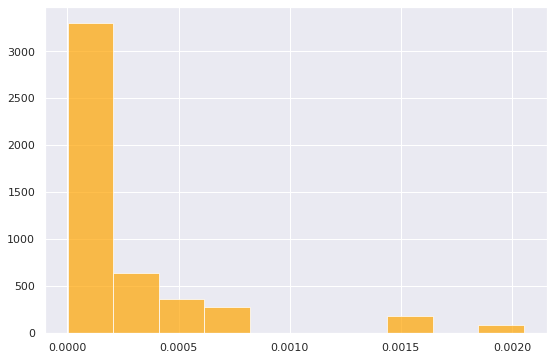

In [948]:
#plot the new distribution
sns.set(rc={'figure.figsize':(9,6)})
plt.hist(bc_values_no0,density=True,alpha=0.7, color='orange')

There are 1941 nodes that have a betweenness centrality of zero. This is a reasonable result. Indeed, there are only 114 different transcription factors among 1994 genes. Furthermore, there are only few nodes with higher betweenness centrality. The node with the highest centrality is a transcription factor named YKL043W.

# Community Detection

## Louvain's method

Louvain's method was chosen to detect communities in the gene regulatory network studied. Indeed, this algorithm is quite fast ( $\mathcal{O}(|E|)$ ) and will allow a quick comparison with the communities found in [1] with Newman’s spectral method. The 'best_partition' method was used. It returns the best partition of the network in terms of best modularity, which is defined as :
 $$Q = \frac{1}{2m} \sum_{ij} [A_{ij} - \frac{k_i k_j}{2m}]\delta (c_i, c_j)$$
Where $m$ is the number of edges, $A$ is the  adjacency matrix, $k_i$ is the degree of the node $i$ , and $c_i$ is the type of the community of the node $c_i$. $\delta(c_i,c_j)$ is set equal to one if $i$ $j$ belong to the same community , and to zero otherwise.
    
There is a stochastic element to this method. Therefore, each run provides a different partition. Though these partitons remain quite similar. A more thorough evaluation, which will not be carried out in this project, would be interesting to quantify these changes. Hence, all comments below will be made on the last run of this method. It is worth mentionning the fact that the interpretation does not change much from one run to another.

### Partition

In [819]:
# community detection algorithm (Louvain's method)
partition = community_louvain.best_partition(DG.to_undirected())

In [820]:
P = [] # list of communities
N = [] # list of nodes
for key, value in partition.items():
    N.append(key)
    P.append(value)
max(P)

17

17 communities were found.

In [821]:
# put the partition in a panda dataframe 
df = pd.DataFrame()
df['Node'] = N
df['Community'] = P

dfLC =df.sort_values(by=['Node'])
dfLC = dfLC.set_index('Node')
dfLC.head()

,Community
Node,
G1,1
G100,4
G1000,1
G1001,1
G1008,2


In [822]:
# Dataframe with gene id and their name :
genes_id_2 = pd.DataFrame()
genes_id_2['Node']= genes_id['ID']
genes_id_2['Name'] = genes_id['Name']
genes_id_2 = genes_id_2.set_index('Node')

In [823]:
# Dataframe joining gene id, their name and their community
community_name =pd.concat([dfLC, genes_id_2],  axis=1,join='inner')
community_name.head()

,Community,Name
Node,,
G1,1,YHR084W
G100,4,YER148W
G1000,1,YMR306W
G1001,1,YDL126C
G1008,2,YDR148C


In [824]:
# Dataframe with genes name and their GO id
Gene_mapping = pd.DataFrame()
Gene_mapping['Name'] = gene_go_mapping.iloc[:,0]
Gene_mapping['GO'] = gene_go_mapping.iloc[:,1]
Gene_mapping =  Gene_mapping.set_index('Name')
Gene_mapping.head()

,GO
Name,
HRA1,GO:0005575
HRA1,GO:0003674
HRA1,GO:0006364
HRA1,GO:0042274
ICR1,GO:0005634


In [825]:
community_name = community_name.reset_index()
community_name =  community_name.set_index('Name')

In [826]:
# Dataframe with genes name, nodes Id, GO Id, and communities
community_name_GO =community_name.join(Gene_mapping, lsuffix='_caller', rsuffix='_other')
community_name_GO.head()

,Node,Community,GO
Name,,,
YAL003W,G1314,6,GO:0005737
YAL003W,G1314,6,GO:0005085
YAL003W,G1314,6,GO:0007010
YAL003W,G1314,6,GO:0033043
YAL003W,G1314,6,GO:0006417


In [827]:
# Contingency table : 
tab = pd.crosstab(community_name_GO['GO'], community_name_GO['Community'])
tab.head()

Community,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
GO,,,,,,,,,,,,,,,,,,
GO:0000054,2,0,0,0,1,4,3,2,0,1,0,1,1,1,0,0,0,1
GO:0000278,9,34,23,4,6,13,12,11,2,1,2,8,1,1,2,0,0,0
GO:0000746,6,26,2,0,2,3,6,2,1,0,1,2,0,0,1,0,0,0
GO:0000902,1,7,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0
GO:0000910,1,8,4,0,2,3,4,3,1,1,0,9,1,0,0,0,0,0


### Heatmap

Genes can be characterized by one or several GO ids, which refer to specific biological functions. Hence, the number of occurence of a GO id in a community can be computed (cf. contingency table above). A heatmap can then be constructed in order to identify more easily which GO ids are associated to which community. The idea would then be to try to characterize each community as a group of genes and transcription factors involved in a specific biological function. 

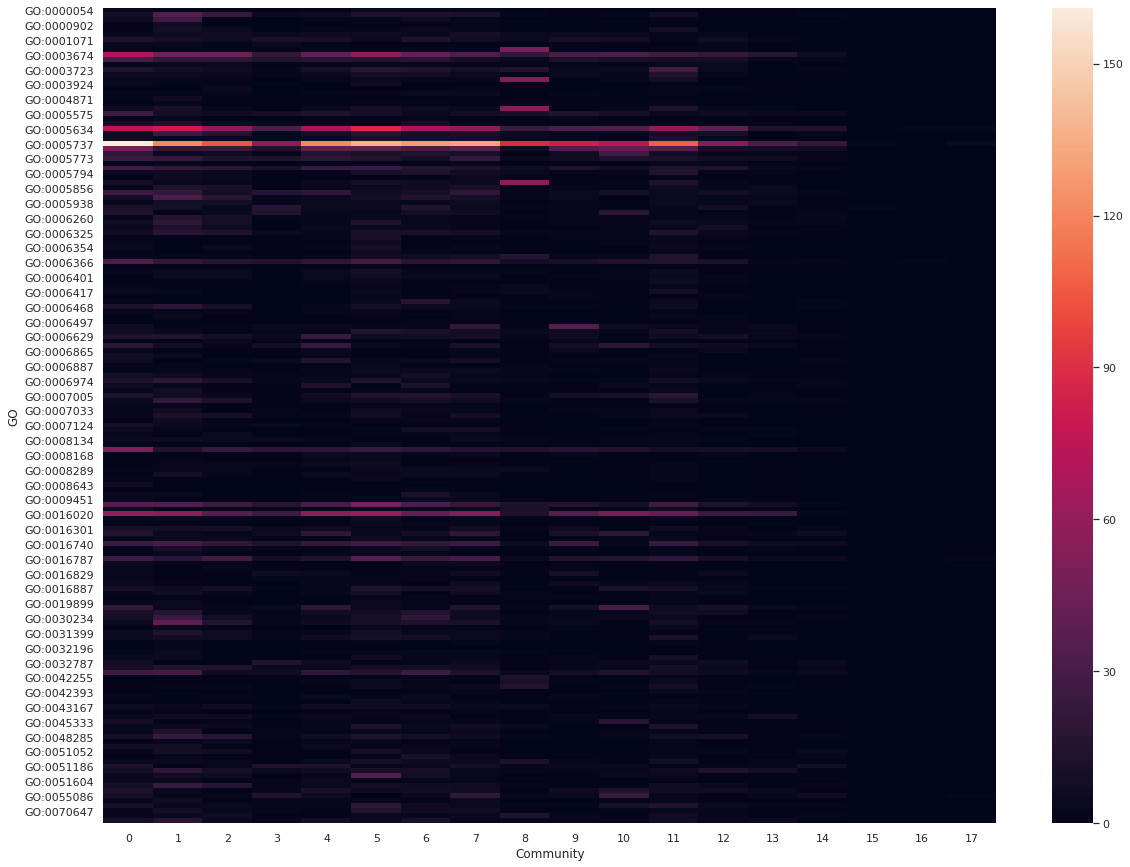

In [828]:
sns.set(rc={'figure.figsize':(20,15)})
sns.heatmap(tab)

It can be noticed in the heatmap above that each community has a different distribution of GO ids. However, it is quite hard to see which GO annotations discriminate the communities. In addition, nothing can be seen regarding community 14 through 17. This might be because these communities are made up of a small number of genes. Thus, we decided to represent the contingency matrix in terms of proportion of the presence of each GO ids: this might allow for a better visualization.

In [829]:
tab2 = pd.crosstab(community_name_GO['GO'], community_name_GO['Community']).apply(lambda r: (r/r.sum())*100, axis=0)

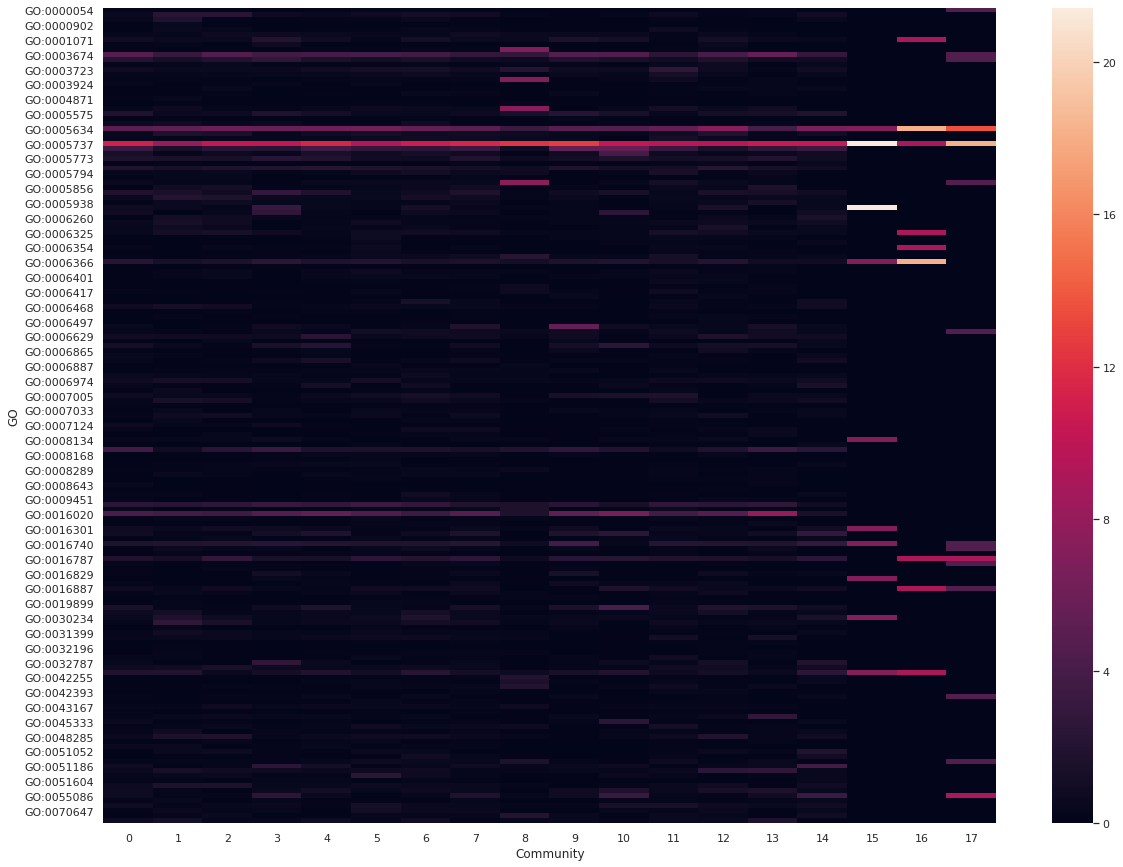

In [830]:
sns.set(rc={'figure.figsize':(20,15)})
sns.heatmap(tab2)

The new heatmap allows to see the GO makeup of communities 14 through 17. However, the other communities are still hard to read. Nonetheless, we can notice that, in both heatmaps, GO:0005737 and GO:0005634 are majoritarily present in almost all the communities. This could be because GO:0005737 stands for cytoplasm (i.e. "All of the contents of a cell excluding the plasma membrane and nucleus, but including other subcellular structure") and GO:0005634 for nucleus. These are cellular compartiments where most of the proteins are located for at least part of their "life". Therefore, in order to get a better visual on the fist 14 communities, the contingency matrix lines corresponding to GO:0005737 and GO:0005634 were removed. 

In [831]:
# remove GO:0005737
tab3 = tab.drop(['GO:0005737'])

In [832]:
# remove GO:0005634
tab4 = tab3.drop(['GO:0005634'])

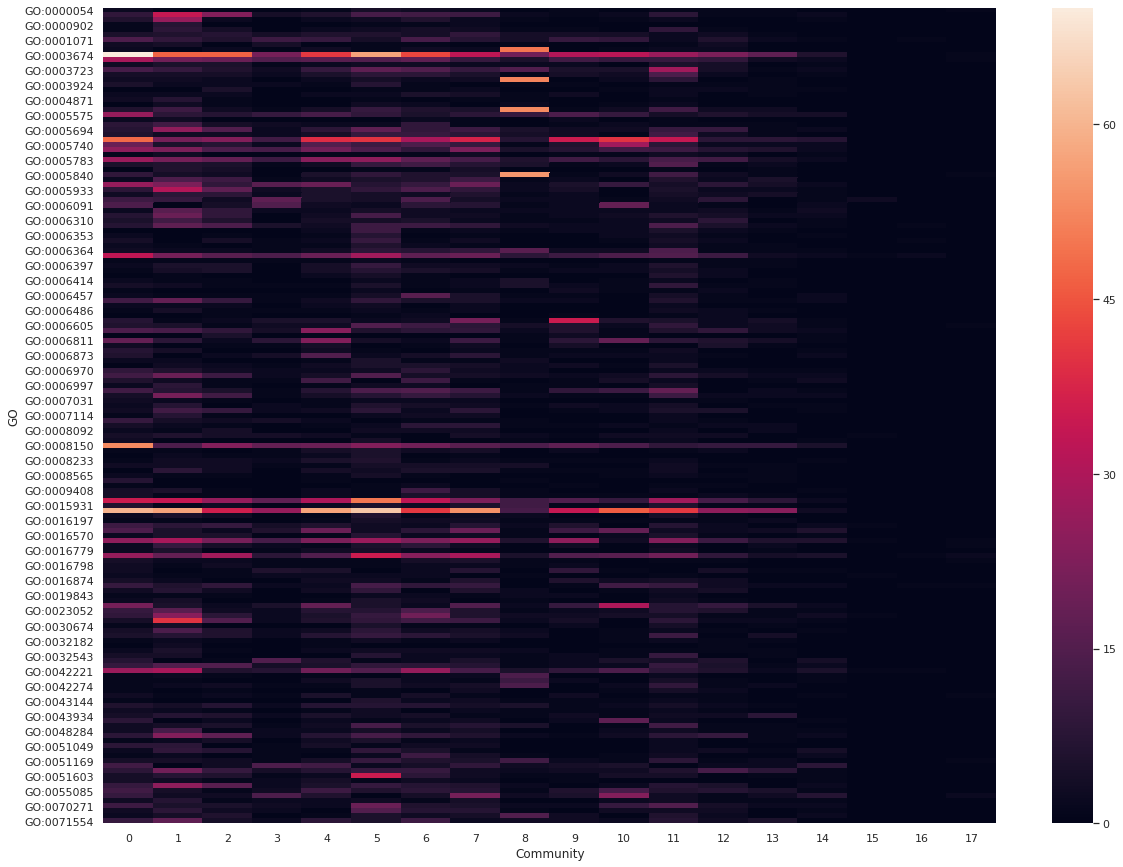

In [833]:
sns.set(rc={'figure.figsize':(20,15)})
sns.heatmap(tab4)

Rmoving those two GO ids indeed helped with the visualization. The composition of a few communities can then be detailed using the following website "http://amigo.geneontology.org":

- **Community 1**: It contains 1498 genes. It has 57 genes annotated with GO:0016020, which stands for membrane. It also has 47 genes annotated with GO:0003674, which stands for molecular function (i.e. "the cellular chemical reactions and pathways involving a nucleobase-containing small molecule: a nucleobase, a nucleoside, or a nucleotide."). It also has 40 genes annotated with GO:0030427, which stands for polarized growth (i.e., "Any part of a cell where non-isotropic growth takes place"), and 34 genes annotated with GO:0000278, which stands for mitotic cell cycle. This community seems to contain functions related to cell growth.

- **Community 5** : It contains 1425 genes. It has 63 genes annotated with GO:0016020, which stands for membrane. It also has 57 genes annotated with GO:0003674, which stands for molecular function and 50 genes that belong to the group G0:0012505, which stands for endomembrane system (which are found in organelles). This community is also characterized by the gene ontology group named GO:0005739 (40 genes), which stands for semiautonomous, self replicating organelle. This community seems to group organelles-related functions.
    
- **Community 8**:It contains 1151 genes. It has 55 genes annotated with GO:0005840, which stands for ribosome, 53 genes annotated with GO:0005198 (structural molecule activity, which means "the action of a molecule that contributes to the structural integrity of a complex or its assembly within or outside a cell"), 52 genes annotated with GO:0003735 (structural constituent of ribosome, which means "the action of a molecule that contributes to the structural integrity of the ribosome") and 50 genes anotated with GO:0002181 (cytoplasmic translation, which means "the chemical reactions and pathways resulting in the formation of a protein in the cytoplasm. This is a ribosome-mediated process"). This community seems to contain mostly genes related to the function of the ribosome.       
    
- **Community 16**:  This is one ofthe smallest community, which contains 14 genes, is mostly characterized by the GO:0005975 id, which stands for chemical reactions and pathways that involve carbohydrates (i.e., any of a group of organic compounds based of the general formula $C_x(H2O)_y$).     

From these results, it seems that communities are indeed composed of genes that are involved in related biological functions. However, this community detection method found about twice as many groups as in [1]. Moreover, the community found here seem to be more specific than those from [1]. A more thorough comparison could elucidate whether this partition is the same as in [1] but with a higher resolution. However, the detailed partitions from [1] are not available (only the name of the communities are provided), so one would need to first try to reproduce them, which is a costly process (Newman's community detection algorithm runs in  $\mathcal{O}(|E|^2|V|)$).

# Conclusion

To conclude, it was shown in this project that the gene regulatory network of *Saccharomyces cerevisiae* can be modeled as  **ultra-small world** and **scale-free**. Indeed, after comparing it to those of different types of random networks, the general degree distribution was fitted to a power law with an exponent between 2 and 3, which is a characteristic of scale-free networks. The out-degree distribution also displays behaviors associated with a scale-free model. However, one would need to fit it with a power-law model to check this hypothesis. 

Transcription factors are the nodes with the highest degree. This is coherent with their function as regulators and the fact that there are very few TFs compared to other types of genes. Additionally, it seems that transcription factors can regulate different number of genes but are not themselves finely regulated (their out-degree tends to be high while their in-degree tends to be low). There are also a few nodes that are not regulated, showcasing either the presence of constitutive genes or a lack of knoweledge. 

Another property of this network is that it is **disassortative**, according to the Pearson degree-degree correlation coefficient. This indicates that TFs regulate mostly other types of genes. The betweenness centrality of each node was also computed. Most nodes have a very low centrality and only a few nodes have a higher centrality. This is consistent with the scale-free model. Moreover, the node with the highest centrality is a TF, which is coherent since only TFs can interact with both other TFs and genes that are not TFs.

Finally, the Louvain **community detection** algorithm was used to partition the network. It was then highlighted that communities tend to be composed of genes involved in related biological functions. However, the resolution of this partition seems to be higher than the one obtained in [1], which seems more relevant. Other community detection algorithm could be tested in further works, such as the Infomap method or the Stochastic Block Model. 

As a perspective, it could be interesting to explore additional metrics in order to gain a better understanding of this network. For instance, other centrality measures, such as the betweenness centrality or the PageRank centrality, could be computed to highlight important nodes in terms of regulation. Rich club coefficients, which represents how well connected nodes are well connected between themselves, could also be an interseting metric.

# References

[1] Daniel Marbach, James C Costello, Robert Küffner, Nicole M Vega, Robert J Prill, Diogo M Camacho, Kyle R Allison, Andrej Aderhold, Richard Bonneau, Yukun Chen, et al. Wisdom of crowds for robust gene network inference. *Nature methods*, 9(8):796, 2012.

[2] Kenzie D MacIsaac, Ting Wang, D Benjamin Gordon, David K Gifford, Gary D Stormo, and Ernest Fraenkel. An improved map of conserved regulatory sites for saccharomyces cerevisiae. BMC bioinformatics, 7(1):113, 2006.

[3]  Zhanzhi Hu, Patrick J Killion, and Vishwanath R Iyer. Genetic reconstruction of a functional transcriptional regulatory network. *Nature genetics*, 39(5):683, 2007.

[4] M. Girvan and M. E. J. Newman, Community structure in social and biological networks, *PNAS* June 11, 2002, 99 (12) 7821-7826.

[5] Almaas, E., Vázquez, A., and Barabási, A.-L., Scale-free Networks in Biology, *Biological Networks*, Chapter 1, pages 1–19.